Importing libraires

In [12]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import datetime
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Lambda,Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from sklearn.utils import shuffle
from tensorflow.keras.applications import ResNet50




Visualising two images

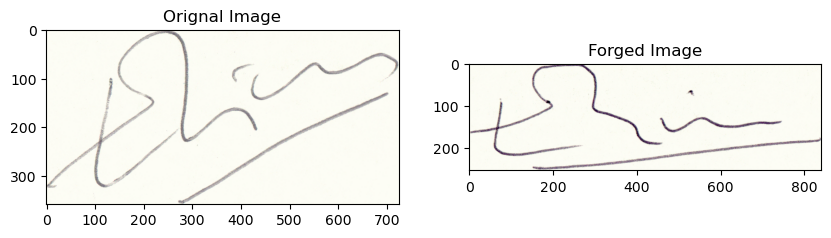

(359, 725, 3)
(255, 841, 3)


In [2]:
#reading file paths
path1 = r"C:\Users\08bur\Desktop\signature_images\sign_data\sign_data\train\001\001_01.PNG" 
path2 = r"C:\Users\08bur\Desktop\signature_images\sign_data\sign_data\train\001_forg\0201001_03.png"

#creating subplots for actual and forged image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#reading the images from their paths
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

#plotting the images 
axes[0].imshow(img1)
axes[0].set_title('Orignal Image')

axes[1].imshow(img2)
axes[1].set_title('Forged Image')
plt.show()

#reading the shape of the images
print(img1.shape)
print(img2.shape)

Defining the read data function to extract images from the directory and store them in a numpy array 

In [5]:
def read_data(dir, data): 
    images1 = []  
    images2 = []  
    labels = []
    
    for j in range(len(data)):
        path = os.path.join(dir, data.iat[j, 0]) # contructing the image path
        img1 = cv2.imread(path)  # reading the image from the path
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) # converting the image into greyscale
        img1 = cv2.resize(img1, (100, 100)) # resizing the image into 100x100 pixels
        images1.append([img1]) # appending the image into the images1 list 

        path = os.path.join(dir, data.iat[j, 1]) # constructing the image path
        img2 = cv2.imread(path) # reading the image from the path
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) # converting the image into greyscale
        img2 = cv2.resize(img2, (100, 100)) # resizing the pixels into 100x100 pixels
        images2.append([img2]) # appending the image into the images2 list

        labels.append(np.array(data.iat[j, 2])) # appending the labels into the labels list

    images1 = np.array(images1).astype(np.float32) / 255.0   # converting into a numpy array and dividing the pixel values by 255 
    images2 = np.array(images2).astype(np.float32) / 255.0   # converting into a numpy array and dividing the pixel values by 255
    labels = np.array(labels).astype(np.float32) # converting the list into a numpy array 
    return images1, images2, labels  


Defining the base CNN layer to extract features from the images 

In [6]:
def build_base_network(input_shape):
    model = Sequential()
    # A convolutional layer is added with 64 filters, a 3x3 kernel size, ReLU activation, and an input shape of (224, 224, 3).
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(input_shape)))
    # Batch Normalization is added.
    model.add(BatchNormalization())                                 
    # A MaxPooling layer with a 2x2 pool size is added after the first convolutional layer.
    model.add(MaxPooling2D((2, 2)))
    # Another convolutional layer is added with 128 filters and a 3x3 kernel size.
    model.add(Conv2D(32, (3, 3), activation='relu'))
    # Batch Normalization is applied again.
    model.add(BatchNormalization())
    # Another MaxPooling layer is added after the second convolutional layer.
    model.add(MaxPooling2D((2, 2)))
    # The model is flattened to prepare for fully connected layers.
    model.add(Flatten())
    # A dense layer with 128 units and ReLU activation is added.
    model.add(Dense(128, activation='relu'))
    # A dense layer with 64 units and ReLU activation is added.
    model.add(Dense(64, activation='relu'))
    return model



Defining the euclidian distance function

In [7]:
def euclidean_distance(vects):
   x, y = vects
   return K.sqrt(K.sum(K.square(x - y), keepdims=True))


Defining the manhattan distance function 

In [8]:
def manhattan_distance(vects):
    x,y = vects
    return K.abs((x - y))

Reading the data and storing the images and labels in a numpy array 

In [9]:

train_dir = r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\train"
train_csv = r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\train_data.csv"
test_dir = r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\test"
test_csv= r"C:\Users\08bur\OneDrive\Desktop\Projects\siamese network\signature_verification_dataset\sign_data\test_data.csv"

#
df_train = pd.read_csv(train_csv, header=None)

df_test = pd.read_csv(test_csv, header=None)

#
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)

#
train_images1, train_images2, train_labels = shuffle(train_images1, train_images2, train_labels)
test_images1, test_images2, test_labels = shuffle(test_images1, test_images2, test_labels)

#
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)
test_images1 = test_images1.reshape(-1, size, size, 1)
test_images2 = test_images2.reshape(-1, size, size, 1)

In [10]:
# checking the shape of the arrays
print( "Shape of train images array = " ,train_images1.shape )       
print( "Shape of test images array = " ,test_images1.shape )       
                    

Shape of train images array =  (23206, 100, 100, 1)
Shape of test images array =  (5748, 100, 100, 1)


Siamese model architecture with the the custom CNN layers to extract features vectors and the manhatan distance function to calculate the difference between the feature vectors

In [19]:
# defining the input shape
input_dim = (100, 100, 1) 

# initializing the base network 
base_network = build_base_network(input_dim)


img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda( manhattan_distance )([feat_vecs_a, feat_vecs_b])

prediction = Dense(1, activation='sigmoid')(distance)

#
earlyStopping_callback = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              restore_best_weight = True) 

model = Model([img_a, img_b], prediction)
model.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 64)        │  2,194,656 │ input_layer_15[0… │
│ (Sequential)        │                   │            │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ sequential_5[0][… │
│                     │                   │            │ sequential_5[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         65 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,194,721 (8.37 MB)

 Trainable params: 2,194,529 (8.37 MB)

 Non-trainable params: 192 (768.00 B)

In [61]:
#
model.compile(loss="binary_crossentropy", optimizer= "adam" 
              , metrics=["accuracy"])

#
history = model.fit([train_images1, train_images2], train_labels, validation_split=.30,
                    batch_size=32, verbose=1, epochs=10, callbacks= earlyStopping_callback)

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.7663 - loss: 0.5974 - val_accuracy: 0.7402 - val_loss: 0.6449
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.9887 - loss: 0.0347 - val_accuracy: 0.8934 - val_loss: 0.2961
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 902s 2s/step - accuracy: 0.9913 - loss: 0.0284 - val_accuracy: 0.7789 - val_loss: 1.4396
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.9868 - loss: 0.0512 - val_accuracy: 0.8141 - val_loss: 1.4176
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 791s 2s/step - accuracy: 0.9947 - loss: 0.0225 - val_accuracy: 0.7483 - val_loss: 0.9602
Epoch 5: early stopping


In [62]:
model.save('custom_base_network_manhanttan_distance.h5')

In [63]:
loss, accuracy = model.evaluate([test_images1, test_images2], test_labels)
print(accuracy)

180/180 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7343 - loss: 0.9261
0.7376478910446167


Result 1 : The above  model gives a 73.76% accuracy on the test set 

----------------------------------

Siamese model architecture with the the custom CNN layers to extract features vectors and the euclidean distance function to calculate the difference between the feature vectors

In [65]:
#
input_dim = (100, 100, 1)

# initializing the base network 
base_network = build_base_network(input_dim)


img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance)([feat_vecs_a, feat_vecs_b])

prediction = Dense(1, activation='sigmoid')(distance)

#
earlyStopping_callback = EarlyStopping(monitor='val_loss',
                              patience=3,
                              verbose=1,
                              restore_best_weight = True) 

model_2 = Model([img_a, img_b], prediction)
model_2.summary()

Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_41      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64)        │  2,194,656 │ input_layer_40[0… │
│ (Sequential)        │                   │            │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (1, 1)            │          0 │ sequential_13[0]… │
│                     │                   │            │ sequential_13[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (1, 1)            │          2 │ lambda_13[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,194,658 (8.37 MB)

 Trainable params: 2,194,466 (8.37 MB)

 Non-trainable params: 192 (768.00 B)

In [67]:
#
model_2.compile(loss="binary_crossentropy", optimizer= "adam" 
              , metrics=["accuracy"])

#
history = model_2.fit([train_images1, train_images2], train_labels, validation_split=.30,
                    batch_size=32, verbose=1, epochs=10, callbacks= earlyStopping_callback)

Epoch 1/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 463s 900ms/step - accuracy: 0.5287 - loss: 2.8792 - val_accuracy: 0.5389 - val_loss: 0.6904
Epoch 2/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 249s 490ms/step - accuracy: 0.5472 - loss: 0.6894 - val_accuracy: 0.5389 - val_loss: 0.6901
Epoch 3/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 295s 580ms/step - accuracy: 0.5529 - loss: 0.6880 - val_accuracy: 0.5389 - val_loss: 0.6901
Epoch 4/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 457s 900ms/step - accuracy: 0.5507 - loss: 0.6881 - val_accuracy: 0.5389 - val_loss: 0.6901
Epoch 5/10
508/508 ━━━━━━━━━━━━━━━━━━━━ 474s 933ms/step - accuracy: 0.5444 - loss: 0.6892 - val_accuracy: 0.5389 - val_loss: 0.6902
Epoch 5: early stopping


In [70]:
model_2.save('custom_base_network_euclidean_distance.h5')

In [71]:
loss, accuracy = model_2.evaluate([test_images1, test_images2], test_labels)
print(accuracy)

180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.4851 - loss: 0.6996
0.48225468397140503


Result 2 : The above  model gives a 48.22% accuracy on the test set 

Conclusion : The manhattan distance function helps to give better results in comparison to the euclidean distance function while differentiating between forged and real images